In [1]:
from matplotlib import pyplot as plt
import numpy as np 
import pandas as pd
import keras
import keras.backend as Kback
from keras import layers
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LSTM, SimpleRNN
from keras.layers.core import Activation
from keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

model_path = 'RNN_regression_PCA_FD3.h5'

import random
random.seed(123)


Using TensorFlow backend.


In [2]:
from math import e

In [28]:
#######
#Data ingestion & processing
######

train_df = pd.read_csv("C:/Users/eduardo.tadeo/OneDrive - INVENSITY GmbH/Master Thesis/Master Thesis/Datasets/CMAPSSData/train_FD003.txt", delimiter = ' ')
test_df  = pd.read_csv("C:/Users/eduardo.tadeo/OneDrive - INVENSITY GmbH/Master Thesis/Master Thesis/Datasets/CMAPSSData/test_FD003.txt", delimiter = ' ')
RUL_test = pd.read_csv("C:/Users/eduardo.tadeo/OneDrive - INVENSITY GmbH/Master Thesis/Master Thesis/Datasets/CMAPSSData/RUL_FD003.txt")
RUL_real = RUL_test

#Unuseful columns deleting 

train_df.drop(['T_EGT', 'SmFan', 'SmLPC', 'SmHPC'], axis = 1, inplace = True)

test_df.drop(['T_EGT', 'SmFan', 'SmLPC', 'SmHPC'], axis = 1, inplace = True)


###TRAIN DATA SET###

# Standarization for both sensor variables and operational conditions

train_df['Cycle_norm'] = train_df['Cycle']
cols_normalize = train_df.columns.difference(['Unit','Cycle','UL','RUL','UL_30','UL_50', 'UL_75'])
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train_df[cols_normalize])
norm_train_df = pd.DataFrame(scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

# Principal Component Analysis Dimensionality Reduction

pca = PCA(.95)

pca.fit(norm_train_df)
transformed_train = pca.transform(scaled_train)

df_transformed_train = pd.DataFrame(transformed_train, index = train_df.index)

join_df = train_df[train_df.columns.difference(cols_normalize)].join(df_transformed_train)
train_df = join_df.reindex()


# Data labeling - Remaining Useful LIfe (RUL) --> Time to failure

RUL = pd.DataFrame(train_df.groupby('Unit')['Cycle'].max()).reset_index()
RUL.columns = ['Unit','UL']
train_df = train_df.merge(RUL, on = ['Unit'], how = 'left')
train_df['RUL'] = train_df['UL'] - train_df['Cycle']


# Data labeling - UL_30 - UL_50 - UL_75 --> Labeling to predict if the turbine is going to fail on les than 30, 50 or 75 cycles

train_df['UL_30'] = np.where(train_df['RUL'] <= 30, 1, 0)
train_df['UL_50'] = np.where(train_df['RUL'] <= 50, 1, 0)
train_df['UL_75'] = np.where(train_df['RUL'] <= 75, 1, 0)




In [29]:
def complete (test_df, seq_length):

    for i in test_df['Unit']:

        test = test_df[test_df['Unit']==i]

        if (test['Cycle'].max()<seq_length):

            print("He entrado en ", i)

            n_cycles = seq_length - test['Cycle'].max()

            new_values = np.zeros((n_cycles.astype(int),test_df.shape[1]))
            new_values[:,2:] = test.iloc[:,2:].mean(axis = 0).to_numpy()
            new_values[:,0] = i
            new_values[:,1] = range(test['Cycle'].max().astype(int)+1, seq_length+1)

            new_values = pd.DataFrame(new_values, columns = test_df.columns)

            test = pd.concat([test,new_values]).reset_index()

            test = test.drop(test.columns[0],axis=1)

            #print(test.head())

            test_df = pd.concat([test_df[test_df['Unit']<i],test,test_df[test_df['Unit']>i]]).reset_index()

            test_df = test_df.drop(test_df.columns[0],axis = 1)


    return test_df


In [30]:
sequence_length = 50

test_df = complete(test_df, sequence_length+1)


He entrado en  37
He entrado en  52
He entrado en  54
He entrado en  88


In [31]:
###TEST DATA SET###


#Normalize data
test_df['Cycle_norm'] = test_df['Cycle']
norm_test_df = pd.DataFrame(scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)

print(norm_train_df.shape,norm_test_df.shape)

#Principal Component Analysis Dimensionality Reduction

transformed_test = pca.transform(norm_test_df)

df_transformed_test = pd.DataFrame(transformed_test, index = test_df.index)

join_df = test_df[test_df.columns.difference(cols_normalize)].join(df_transformed_test)
test_df = join_df.reindex()

# We use the ground truth dataset to generate labels for the test data.
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('Unit')['Cycle'].max()).reset_index()
rul.columns = ['Unit', 'max']
RUL_test.columns = ['more']
RUL_test['Unit'] = RUL_test.index + 1
RUL_test['max'] = rul['max'] + RUL_test['more']
RUL_test.drop('more', axis=1, inplace=True)

# generate RUL for test data
test_df = test_df.merge(RUL_test, on=['Unit'], how='left')
test_df['RUL'] = test_df['max'] - test_df['Cycle']
#test_df.drop('max', axis=1, inplace=True)

#Data labeling - UL_30 - UL_50 - UL_75 --> Labeling to predict if the turbine is going to fail on les than 30, 50 or 75 cycles

test_df['UL_30'] = np.where(test_df['RUL'] <= 30, 1, 0)
test_df['UL_50'] = np.where(test_df['RUL'] <= 50, 1, 0)
test_df['UL_75'] = np.where(test_df['RUL'] <= 75, 1, 0)






(24720, 25) (16624, 25)


In [ ]:
test_df.head()

In [ ]:
train_df.iloc[:,2:-5].head()

In [32]:
#####
#Data formatting#
####

# Data will be input into the RNN in windows with a certain size
sequence_length = 50

# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # for one id I put all the rows in a single matrix
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows and sequence_length is equal to 50
    # so zip iterate over two following list of numbers (0,112),(50,192)
    # 0 50 -> from row 0 to row 50
    # 1 51 -> from row 1 to row 51
    # 2 52 -> from row 2 to row 52
    # ...
    # 111 191 -> from row 111 to 191
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

sequence_cols = list(train_df.columns[2:-5].values)
#sequence_cols.extend(["Cycle_norm"])

#val=list(gen_sequence(train_df[train_df['Unit']==1], sequence_length, sequence_cols))

seq_gen = (list(gen_sequence(train_df[train_df['Unit']==id], sequence_length, sequence_cols)) 
           for id in train_df['Unit'].unique())


# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
print(seq_array.shape)

def gen_labels(id_df, seq_length, label):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # For one id I put all the labels in a single matrix.
    # For example:
    # [[1]
    # [4]
    # [1]
    # [5]
    # [9]
    # ...
    # [200]] 
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    # I have to remove the first seq_length labels
    # because for one id the first sequence of seq_length size have as target
    # the last label (the previus ones are discarded).
    # All the next id's sequences will have associated step by step one label as target.
    return data_matrix[seq_length:num_elements, :]

# generate labels
label_gen = [gen_labels(train_df[train_df['Unit']==id], sequence_length, ['RUL']) 
             for id in train_df['Unit'].unique()]

label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape


(19720, 50, 11)


(19720, 1)

In [33]:
label_array[label_array >130] = 130

In [34]:
def r2_keras(y_true, y_pred):
    ##Coefficient of Determination##

    SS_res = Kback.sum(Kback.square(y_true - y_pred))
    SS_tot = Kback.sum(Kback.square( y_true - Kback.mean(y_true)))
    return (1 - SS_res/(SS_tot + Kback.epsilon()))

def Computed_Score(y_true, y_pred):
    ##Computed score used in the challenge

    a1 = 10
    a2 = 13
    score = 0
    d = y_pred - y_true

    score_vec = np.zeros(len(y_true))

    for i in range(len(d)): 
        if d[i]<0:
            score_vec[i] = (e**(-d[i]/a1) - 1)
            score += score_vec[i]
        else : 
            score_vec[i] = (e**(d[i]/a2) - 1)
            score += score_vec[i]

    fig_hist = plt.figure(figsize=(10,5))
    plt.hist(score_vec, color = "#3f729a" )
    hist_data, _, _ = plt.hist(score_vec, color = "#3f729a" )
    print(hist_data)
    plt.ylabel("Frequency")
    plt.xlabel("Score")

    score_low = 0
    score_high = 0

    for i in range(len(d)):

        if score_vec[i] < 50:
            score_low += score_vec[i]
        else:
            score_high += score_vec[i]

    

    print(score_low, score_high)
    print(score_low/(score_low + score_high))

    plt.figure()
    plt.plot(range(100),score_vec)

    return score



In [10]:
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

RNN_model = Sequential()
RNN_model.add(LSTM(
    input_shape = (sequence_length, nb_features),
    units = 50,
    return_sequences = True))
RNN_model.add(Dropout(0.2))
RNN_model.add(LSTM(units = 25, return_sequences = True))
RNN_model.add(Dropout(0.2))
RNN_model.add(LSTM(units = 25, return_sequences = False))
RNN_model.add(Dropout(0.2))
RNN_model.add(Dense(units = nb_out))
RNN_model.add(Activation("linear"))
RNN_model.compile(loss = 'mean_squared_error', optimizer = 'rmsprop', metrics = ['mae', r2_keras])

print(RNN_model.summary())

result = RNN_model.fit(seq_array, label_array, epochs = 100, batch_size = 100, validation_split = 0.05, verbose = 1,
    callbacks = [keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0, patience=10, verbose = 0, mode = 'min'), 
        keras.callbacks.ModelCheckpoint(model_path, monitor = 'val_loss', save_best_only = True, mode = 'min', verbose = 0)]
    )
print(result.history.keys())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 50)            12400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 25)            7600      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 25)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 25)                5100      
_________________________________________________________________
dropout_3 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

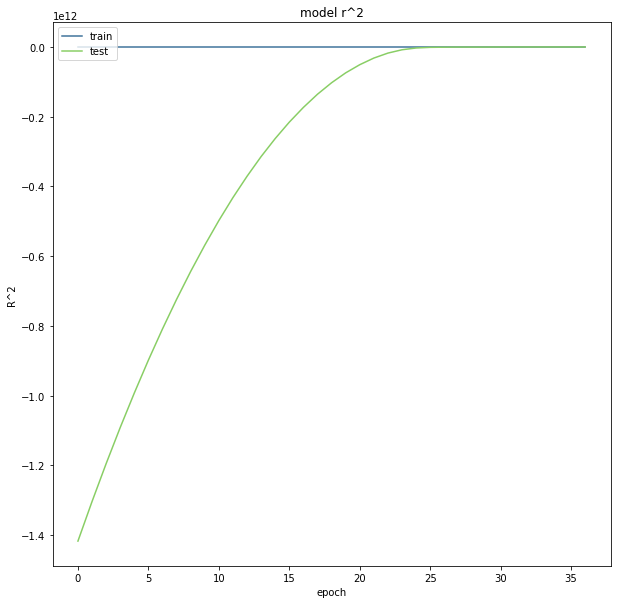

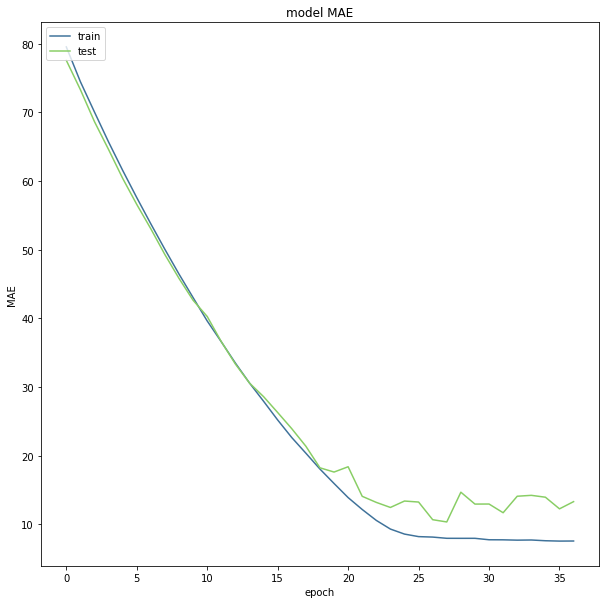

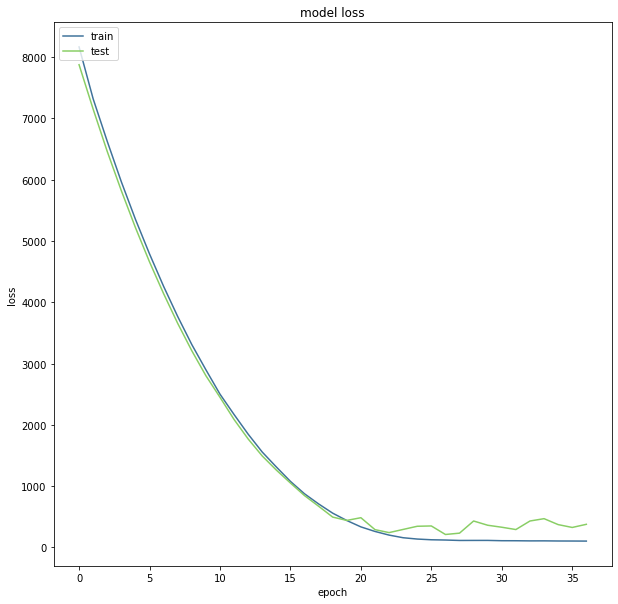

In [11]:
# summarize history for R^2
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(result.history['r2_keras'], color="#3f729a")
plt.plot(result.history['val_r2_keras'], color="#89ce65")
plt.title('model r^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#fig_acc.savefig("model_r2.png")

# summarize history for MAE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(result.history['mae'], color="#3f729a")
plt.plot(result.history['val_mae'], color="#89ce65")
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#fig_acc.savefig("model_mae.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(result.history['loss'], color="#3f729a")
plt.plot(result.history['val_loss'], color="#89ce65")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#fig_acc.savefig("model_regression_loss.png")


In [35]:
# training metrics
scores = RNN_model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('\nMAE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))

y_pred = RNN_model.predict(seq_array,verbose=1, batch_size=200)
y_true = label_array

#test_set = pd.DataFrame(y_pred)
#test_set.to_csv('submit_train.csv', index = None)

19720/19720 [==============================] - 9s 453us/step

MAE: 3.5919926166534424

R^2: -405510944.0
19720/19720 [==============================] - 8s 414us/step



MAE: 11.592430114746094

R^2: 0.8789161443710327


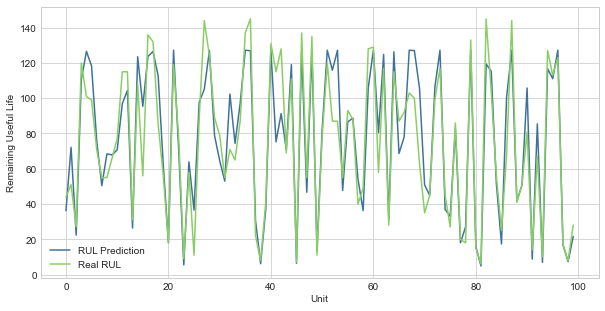

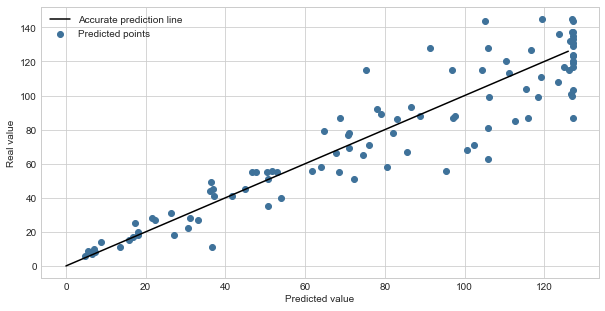

In [36]:
# We pick the last sequence for each id in the test data
seq_array_test_last = [test_df[test_df['Unit']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['Unit'].unique() if len(test_df[test_df['Unit']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
#print("seq_array_test_last")
#print(seq_array_test_last)
#print(seq_array_test_last.shape)

# Similarly, we pick the labels
#print("y_mask")
y_mask = [len(test_df[test_df['Unit']==id]) >= sequence_length for id in test_df['Unit'].unique()]
label_array_test_last = test_df.groupby('Unit')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
#print(label_array_test_last.shape)
#print("label_array_test_last")
#print(label_array_test_last)

# if best iteration's model was saved then load and use it
if os.path.isfile(model_path):
    
    estimator = load_model(model_path,custom_objects={'r2_keras': r2_keras})

    # test metrics
    scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
    print('\nMAE: {}'.format(scores_test[1]))
    print('\nR^2: {}'.format(scores_test[2]))

    y_pred_test = estimator.predict(seq_array_test_last)
    y_true_test = label_array_test_last

    test_set = pd.DataFrame(y_pred_test)
    test_set.to_csv('submit_test.csv', index = None)

    plt.style.use('seaborn-whitegrid')

    # Plot in blue color the predicted data and in green color the
    # actual data to verify visually the accuracy of the model.
    fig_verify = plt.figure(figsize=(10, 5))
    plt.plot(y_pred_test, color="#3f729a")
    plt.plot(y_true_test, color="#89ce65")
    plt.ylabel('Remaining Useful Life')
    plt.xlabel('Unit')
    plt.legend(['RUL Prediction', 'Real RUL'], loc='best')
    plt.show()
    fig_verify.savefig("model_regression_verify.png")

    #Plot the results

    fig_predict = plt.figure(figsize = (10,5))
    plt.scatter(y_pred_test, y_true_test, color = "#3f729a")
    plt.plot(range(y_pred_test.max().astype(int)),range(y_pred_test.max().astype(int)), color = "black")
    plt.ylabel('Real value')
    plt.xlabel('Predicted value')
    plt.legend(['Accurate prediction line', 'Predicted points'])
    plt.show()

[82. 10.  2.  1.  2.  0.  0.  1.  0.  2.]
341.96022951602936 52.04570388793945
0.8679062941050237
The computed challenge score is: S = 394.0059334039688


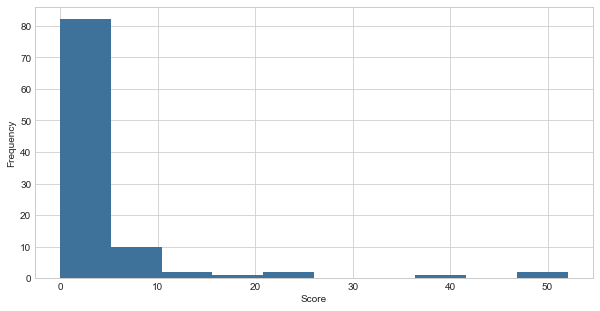

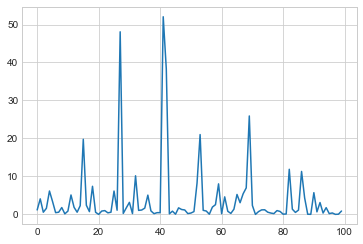

In [38]:
print("The computed challenge score is: S = {}".format(Computed_Score(y_true_test, y_pred_test)))

The model score is: 394.00596440091334
The model accuracy is: 65.0
The model MAE is: 11.592430114746094
The model MSE is : 246.8483984375
The model Mean Absolute Percentage Error (MAPE) is: 17.185462951660156
The model Mean Absolute Percentage Error 2 (MAPE_2) is: 525.0109931518912


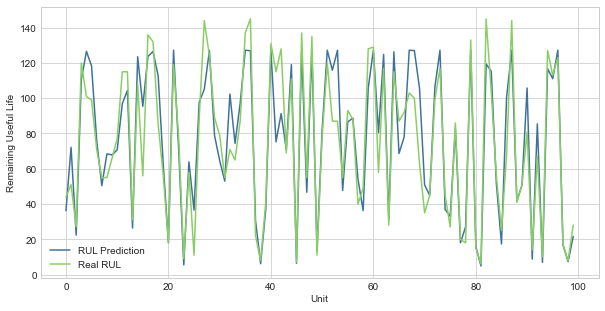

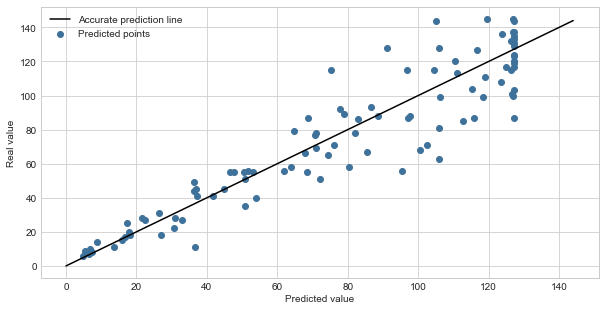

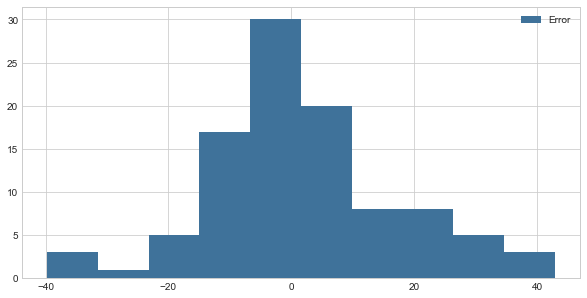

In [39]:
from Perform_function import perform_func 
_, _, _, _, _, _ = perform_func(y_pred_test, y_true_test, test_df.groupby('Unit').max()['Cycle'].to_numpy())

In [16]:
train_predictions = RNN_model.predict(seq_array)
train_predictions.shape

(19720, 1)

In [40]:
train_df['RUL_predict'] = 0
indice_retransf = 0
for i in train_df['Unit'].unique():

    print(i)

    max_indice = train_df.loc[train_df['Unit']==i,'Cycle'].max() + indice_retransf -50

    print()

    print(train_df.loc[(train_df['Unit']==i)&(train_df['Cycle']>50), 'RUL_predict'].shape)
    print(train_predictions[indice_retransf:max_indice,0].shape)


    train_df.loc[(train_df['Unit']==i)&(train_df['Cycle']>50), 'RUL_predict'] = train_predictions[indice_retransf:max_indice,0]

    indice_retransf += train_df.loc[train_df['Unit']==i,'Cycle'].max() - 50

1

(209,)
(209,)
2

(203,)
(203,)
3

(172,)
(172,)
4

(222,)
(222,)
5

(163,)
(163,)
6

(228,)
(228,)
7

(374,)
(374,)
8

(217,)
(217,)
9

(356,)
(356,)
10

(431,)
(431,)
11

(147,)
(147,)
12

(120,)
(120,)
13

(135,)
(135,)
14

(157,)
(157,)
15

(152,)
(152,)
16

(294,)
(294,)
17

(262,)
(262,)
18

(397,)
(397,)
19

(179,)
(179,)
20

(288,)
(288,)
21

(170,)
(170,)
22

(142,)
(142,)
23

(146,)
(146,)
24

(444,)
(444,)
25

(143,)
(143,)
26

(193,)
(193,)
27

(270,)
(270,)
28

(150,)
(150,)
29

(173,)
(173,)
30

(168,)
(168,)
31

(133,)
(133,)
32

(139,)
(139,)
33

(181,)
(181,)
34

(409,)
(409,)
35

(181,)
(181,)
36

(274,)
(274,)
37

(274,)
(274,)
38

(151,)
(151,)
39

(238,)
(238,)
40

(138,)
(138,)
41

(245,)
(245,)
42

(143,)
(143,)
43

(271,)
(271,)
44

(130,)
(130,)
45

(155,)
(155,)
46

(154,)
(154,)
47

(219,)
(219,)
48

(124,)
(124,)
49

(206,)
(206,)
50

(111,)
(111,)
51

(140,)
(140,)
52

(172,)
(172,)
53

(114,)
(114,)
54

(144,)
(144,)
55

(475,)
(475,)
56

(145,)
(145,)
5

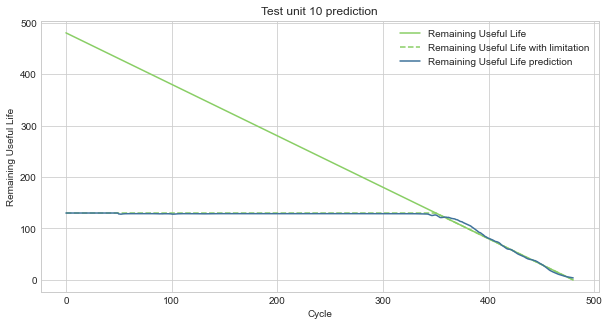

In [46]:
unit = 10

train_df['RUL_tuned']=train_df['RUL']
train_df.loc[train_df['RUL']>130,'RUL_tuned'] = 130
train_df.loc[train_df['Cycle']<=50,'RUL_predict'] = 130


plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize = (10,5))

ax = fig.add_subplot(111)
ax.plot(range(len(train_df[train_df['Unit']==unit])), train_df[train_df['Unit']==unit]['RUL'], color = "#89ce65", label = "Remaining Useful Life")

ax.plot(range(len(train_df[train_df['Unit']==unit])), train_df[train_df['Unit']==unit]['RUL_tuned'], color = "#89ce65", label = "Remaining Useful Life with limitation", linestyle = '--')
#ax.plot(range(len(train_df[train_df['Unit']==unit + v])), train_df[train_df['Unit']==unit+v]['RUL'], color = "#89ce65", label = "Remaining Useful Life")
#ax.plot(range(len(train_df[train_df['Unit']==unit])), Y_tuned[train_df.loc[train_df['Unit']==unit,:].index], color ="#89ce65", label = "Remaining Useful Life with limitation", linestyle = '--')
ax.plot(range(len(train_df[train_df['Unit']==unit])), train_df[train_df['Unit']==unit]['RUL_predict'], color ="#3f729a", label = "Remaining Useful Life prediction")


ax.set_ylabel("Remaining Useful Life")
ax.set_xlabel("Cycle")
ax.set_title("Test unit 10 prediction")

ax.legend()


In [ ]:
unit = 10

plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize = (10,5))

ax = fig.add_subplot(111)

ax.plot(range(len(train_df[train_df['Unit']==unit])), train_df[train_df['Unit']==unit]['RUL'], color = "#89ce65", label = "Remaining Useful Life")
#ax.plot(range(len(train_df[train_df['Unit']==unit])), Y_tuned[train_df.loc[train_df['Unit']==unit,:].index], color ="#89ce65", label = "Remaining Useful Life with limitation", linestyle = '--')
ax.plot(range(len(train_df[train_df['Unit']==unit])), train_df[train_df['Unit']==unit]['RUL_predict'], color ="#3f729a", label = "Remaining Useful Life prediction")


ax.set_ylabel("Remaining Useful Life")
ax.set_xlabel("Cycle")
ax.set_title("Test unit 10 prediction")

ax.legend()


In [19]:
test_proof = pd.DataFrame([test_df[test_df['Unit']==id].iloc[-1,:]
                for id in test_df['Unit'].unique()]).reset_index(drop = True)

error_df = pd.DataFrame()
error_df[['Unit','Cycle','RUL']] = test_proof[['Unit','Cycle','RUL']]
error_df['error'] =  np.abs(y_pred_test - y_true_test)

error_df['Group'] = 0
error_df.loc[error_df['Cycle'] <= 20, 'Group'] = 1
error_df.loc[(error_df['Cycle'] <= 40) & (error_df['Cycle'] > 20) , 'Group'] = 2
error_df.loc[(error_df['Cycle'] <= 60) & (error_df['Cycle'] > 40) , 'Group'] = 3
error_df.loc[(error_df['Cycle'] <= 80) & (error_df['Cycle'] > 60) , 'Group'] = 4
error_df.loc[(error_df['Cycle'] <= 100) & (error_df['Cycle'] > 80) , 'Group'] = 5
error_df.loc[(error_df['Cycle'] <= 120) & (error_df['Cycle'] > 100) , 'Group'] = 6
error_df.loc[(error_df['Cycle'] <= 140) & (error_df['Cycle'] > 120) , 'Group'] = 7
error_df.loc[(error_df['Cycle'] > 140) , 'Group'] = 8

error_df['Group_RUL'] = 0
error_df.loc[error_df['RUL'] <= 20, 'Group_RUL'] = 1
error_df.loc[(error_df['RUL'] <= 40) & (error_df['RUL'] > 20) , 'Group_RUL'] = 2
error_df.loc[(error_df['RUL'] <= 60) & (error_df['RUL'] > 40) , 'Group_RUL'] = 3
error_df.loc[(error_df['RUL'] <= 80) & (error_df['RUL'] > 60) , 'Group_RUL'] = 4
error_df.loc[(error_df['RUL'] <= 100) & (error_df['RUL'] > 80) , 'Group_RUL'] = 5
error_df.loc[(error_df['RUL'] <= 120) & (error_df['RUL'] > 100) , 'Group_RUL'] = 6
error_df.loc[(error_df['RUL'] <= 140) & (error_df['RUL'] > 120) , 'Group_RUL'] = 7
error_df.loc[(error_df['RUL'] > 140) , 'Group_RUL'] = 8

In [20]:
error_grouped  = error_df.groupby('Group').mean()

error_grouped_RUL = error_df.groupby('Group_RUL').mean()

error_grouped

,Unit,Cycle,RUL,error,Group_RUL
Group,,,,,
3,61.500000,52.666667,119.000000,19.513237,6.500000
4,41.875000,71.000000,117.875000,14.120246,6.250000
5,57.000000,88.285714,115.142857,16.216749,6.285714
6,46.187500,111.750000,84.812500,11.916414,4.625000
7,29.888889,130.444444,71.000000,20.566833,4.111111
8,54.425926,225.185185,56.907407,8.146671,3.296296


In [21]:
error_grouped_RUL

,Unit,Cycle,RUL,error,Group
Group_RUL,,,,,
1,64.928571,240.928571,12.285714,4.019289,7.928571
2,56.666667,210.444444,29.222222,7.847148,7.666667
3,43.777778,185.777778,51.444444,9.330248,7.555556
4,41.166667,163.166667,71.000000,14.590543,7.166667
5,52.000000,146.533333,89.866667,16.496183,6.333333
6,44.000000,118.666667,112.866667,13.962515,5.533333
7,51.769231,133.615385,130.769231,10.240232,6.000000
8,59.000000,85.000000,144.500000,24.828537,4.500000


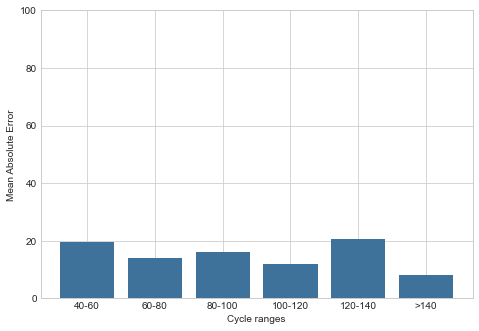

In [22]:
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
ratios = ['40-60', '60-80', '80-100', '100-120','120-140', '>140']
errors = error_grouped['error']
ax.bar(ratios,errors,color="#3f729a")
plt.ylabel("Mean Absolute Error")
plt.xlabel("Cycle ranges")
plt.ylim(0,100)
plt.show()

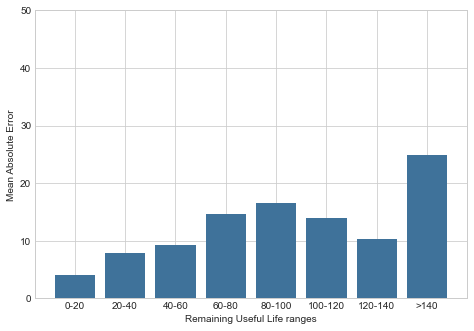

In [25]:
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
ratios = ['0-20','20-40', '40-60', '60-80', '80-100', '100-120','120-140', '>140']
errors = error_grouped_RUL['error']
ax.bar(ratios,errors,color="#3f729a")
plt.ylabel("Mean Absolute Error")
plt.xlabel("Remaining Useful Life ranges")
plt.ylim(0,50)
plt.show()

In [ ]:
seq_gen_testing = (list(gen_sequence(test_df[test_df['Unit']==id], sequence_length, sequence_cols)) 
           for id in test_df['Unit'].unique())

seq_array_testing = np.concatenate(list(seq_gen_testing)).astype(np.float32)

seq_array_testing.shape

In [ ]:
test_prediction = RNN_model.predict(seq_array_testing)
test_prediction.shape

In [ ]:
test_df['RUL_predict'] = 0
indice_retransf = 0
for i in test_df['Unit'].unique():

    print(i)

    max_indice = (test_df.loc[test_df['Unit']==i,'Cycle'].max() + indice_retransf -50).astype(int)

    print(indice_retransf)
    print(max_indice)

    print(test_df.loc[(test_df['Unit']==i)&(test_df['Cycle']>50), 'RUL_predict'].shape)
    print(test_prediction[indice_retransf:max_indice,0].shape)


    test_df.loc[(test_df['Unit']==i)&(test_df['Cycle']>50), 'RUL_predict'] = test_prediction[indice_retransf:max_indice,0]

    indice_retransf += (test_df.loc[test_df['Unit']==i,'Cycle'].max() - 50).astype(int)

In [ ]:
test_prediction.shape

In [ ]:
test_df[test_df['Unit']==83][['RUL','RUL_predict']]

In [ ]:
unit = 83

for unit in test_df['Unit'].unique():
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize = (10,5))

    ax = fig.add_subplot(111)

    ax.plot(range(len(test_df[test_df['Unit']==unit])), test_df[test_df['Unit']==unit]['RUL'], color = "#89ce65", label = "Remaining Useful Life")
    #ax.plot(range(len(train_df[train_df['Unit']==unit])), Y_tuned[train_df.loc[train_df['Unit']==unit,:].index], color ="#89ce65", label = "Remaining Useful Life with limitation", linestyle = '--')
    ax.plot(range(len(test_df[test_df['Unit']==unit])), test_df[test_df['Unit']==unit]['RUL_predict'], color ="#3f729a", label = "Remaining Useful Life prediction")


    ax.set_ylabel("Remaining Useful Life")
    ax.set_xlabel("Cycle")
    ax.set_title("Test unit 10 prediction")

    ax.legend()
